In [1]:
import pandas as pd
data = pd.read_csv(   'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
X = data.drop(columns=['Sales'])
y = data['Sales']

In [3]:
import theano.tensor as tt
def saturate(x, a):
    return 1 - tt.exp(-a*x)
def carryover(x, strength, length=21):
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
import pymc3 as pm
with pm.Model() as mmm:
    channel_contributions = []
    
    for channel in X.columns:
        coef = pm.Exponential(f'coef_{channel}', lam=0.0001)
        sat = pm.Exponential(f'sat_{channel}', lam=1)
        car = pm.Beta(f'car_{channel}', alpha=2, beta=2)
        
        channel_data = X[channel].values
        channel_contribution = pm.Deterministic(
            f'contribution_{channel}',
            coef * saturate(
                carryover(
                    channel_data,
                    car
                ),
                sat
            )
        )
        
        channel_contributions.append(channel_contribution)
        
    base = pm.Exponential('base', lam=0.0001)
    noise = pm.Exponential('noise', lam=0.0001)
    
    sales = pm.Normal(
        'sales',
        mu=sum(channel_contributions) + base,
        sigma=noise,
        observed=y
    )
    
    trace = pm.sample(return_inferencedata=True, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
E:\anaconda\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, base, car_Banners, sat_Banners, coef_Banners, car_Radio, sat_Radio, coef_Radio, car_TV, sat_TV, coef_TV]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 59779 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 180 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8955390857865734, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'coef_TV'}>,
        <AxesSubplot:title={'center':'sat_TV'}>,
        <AxesSubplot:title={'center':'car_TV'}>],
       [<AxesSubplot:title={'center':'coef_Radio'}>,
        <AxesSubplot:title={'center':'sat_Radio'}>,
        <AxesSubplot:title={'center':'car_Radio'}>],
       [<AxesSubplot:title={'center':'coef_Banners'}>,
        <AxesSubplot:title={'center':'sat_Banners'}>,
        <AxesSubplot:title={'center':'car_Banners'}>],
       [<AxesSubplot:title={'center':'base'}>,
        <AxesSubplot:title={'center':'noise'}>, <AxesSubplot:>]],
      dtype=object)

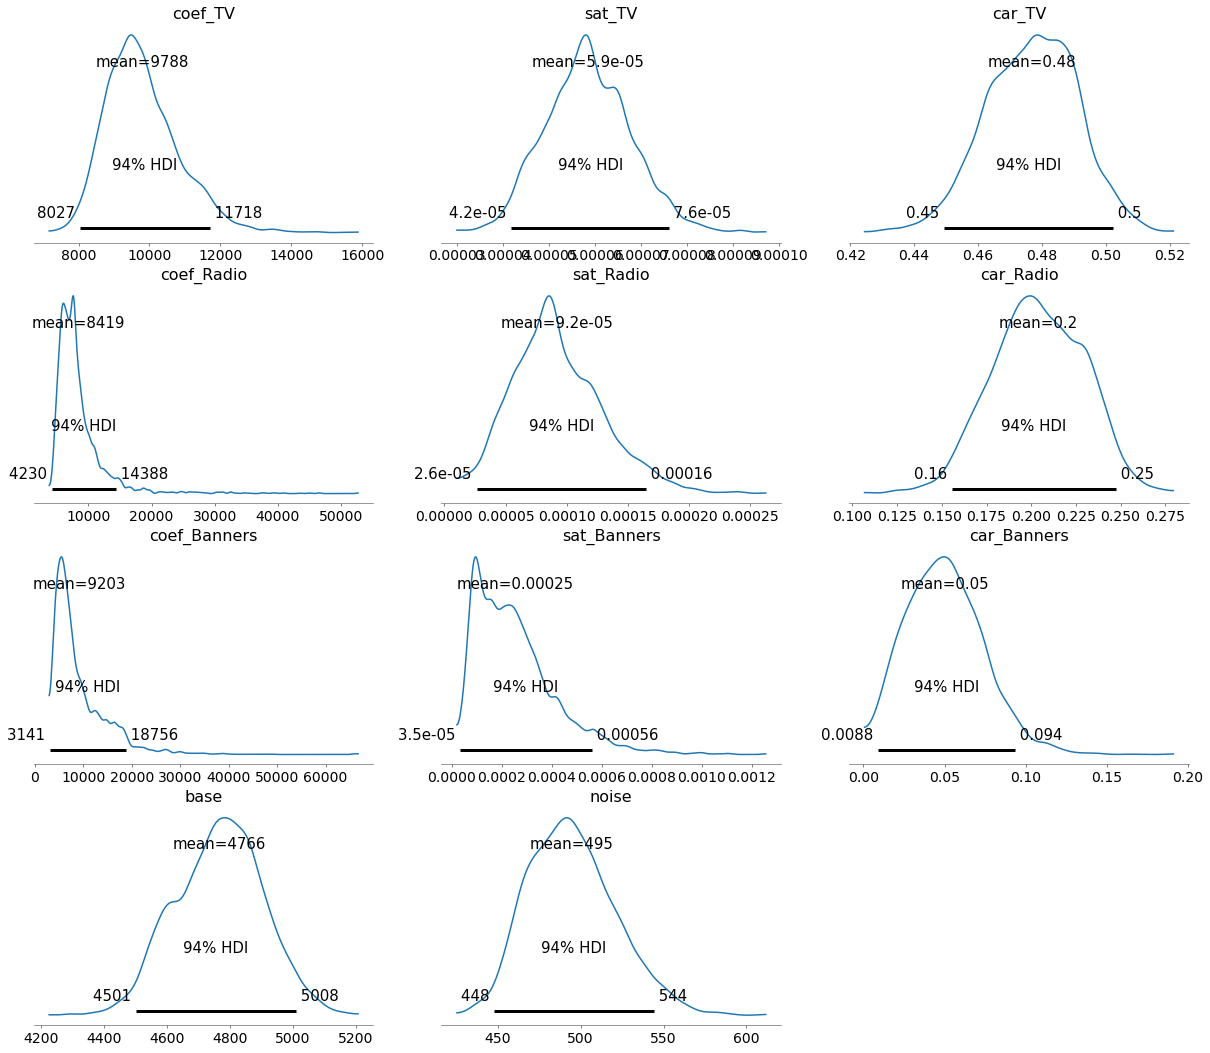

In [5]:
import arviz as az
az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

E:\anaconda\lib\site-packages\arviz\plots\jointplot.py:145: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot:xlabel='coef_TV', ylabel='sat_TV'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

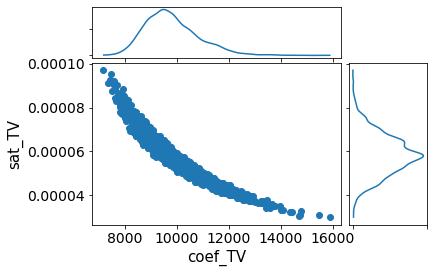

In [7]:
az.plot_joint(
    trace,
    var_names=['coef_TV', 'sat_TV'],
)

E:\anaconda\lib\site-packages\arviz\plots\jointplot.py:145: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot:xlabel='car_TV', ylabel='sat_TV'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

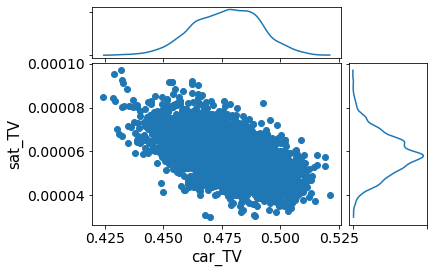

In [8]:
az.plot_joint(
    trace,
    var_names=['car_TV', 'sat_TV'],
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
with mmm:
    posterior = pm.sample_posterior_predictive(trace)
means = posterior['sales'].mean(0)
stds = posterior['sales'].std(0)
plt.figure(figsize=(20, 8))
plt.plot(y.values, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()

In [ ]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'contribution_{channel}']
            .values
            .reshape(4000, 200)
            .mean(0)
           )
channels = ['Banners', 'Radio', 'TV']
unadj_contributions = pd.DataFrame(
    {'Base': trace.posterior['base'].values.mean()},
    index=X.index
)
for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )
ax = (adj_contributions
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)